# Простая демонстрация работы модели

Показывает черно-белое изображение, оригинальное цветное и результаты работы моделей - лучшей по loss train, по loss val, с конкретным номером эпохи

In [1]:
import torch
from pathlib import Path
from dotenv import dotenv_values
import matplotlib.pyplot as plt
from PIL import Image
import torchvision

import colorize_model
import utils


# Настройки

In [2]:
# загрузить параметры
settings = {
    **dotenv_values("settings")
}

SEED = int(settings['SEED'])
IMAGE_SIZE = int(settings['IMAGE_SIZE'])

root_folder = Path.cwd()
print(f'root_folder: {root_folder}')

data_folder = Path(root_folder, settings['DATA_SUBFOLDER'])
print(f'dataset_folder: {data_folder}')
if not Path.is_dir(data_folder):
    data_folder.mkdir()

models_folder = Path(root_folder, settings['MODELS_SUBFOLDER'])
print(f'models_folder: {models_folder}')
if not Path.is_dir(models_folder):
    models_folder.mkdir()

output_folder = Path(root_folder, settings['OUTPUT_SUBFOLDER'])
print(f'output_folder: {output_folder}')
if not Path.is_dir(output_folder):
    output_folder.mkdir()

DATASET_ZIP_FILENAME_01 = settings['DATASET_ZIP_FILENAME_01']
GRAY_SUBFOLDER_01 = settings['GRAY_SUBFOLDER_01']
COLOR_SUBFOLDER_01 = settings['COLOR_SUBFOLDER_01']

dataset_zip_01 = Path(data_folder, f'{DATASET_ZIP_FILENAME_01}.zip')
extracted_dataset_folder_01 = Path(data_folder, DATASET_ZIP_FILENAME_01)

gray_folder_01 = Path(extracted_dataset_folder_01, GRAY_SUBFOLDER_01)
color_folder_01 = Path(extracted_dataset_folder_01, COLOR_SUBFOLDER_01)
print(f'gray_folder_01: {gray_folder_01}')
print(f'color_folder_01: {color_folder_01}')    

DATASET_ZIP_FILENAME_02 = settings['DATASET_ZIP_FILENAME_02']
GRAY_SUBFOLDER_02 = settings['GRAY_SUBFOLDER_02']
COLOR_SUBFOLDER_02 = settings['COLOR_SUBFOLDER_02']

dataset_zip_02 = Path(data_folder, f'{DATASET_ZIP_FILENAME_02}.zip')
extracted_dataset_folder_02 = Path(data_folder, DATASET_ZIP_FILENAME_02)

gray_folder_02 = Path(extracted_dataset_folder_02, GRAY_SUBFOLDER_02)
color_folder_02 = Path(extracted_dataset_folder_02, COLOR_SUBFOLDER_02)
print(f'gray_folder_02: {gray_folder_02}')
print(f'color_folder_02: {color_folder_02}')    

GRAY_SUBFOLDER_02_TEST = settings['GRAY_SUBFOLDER_02_TEST']
COLOR_SUBFOLDER_02_TEST = settings['COLOR_SUBFOLDER_02_TEST']
gray_folder_02_test = Path(extracted_dataset_folder_02, GRAY_SUBFOLDER_02_TEST)
color_folder_02_test = Path(extracted_dataset_folder_02, COLOR_SUBFOLDER_02_TEST)
print(f'gray_folder_02: {gray_folder_02_test}')
print(f'color_folder_02: {color_folder_02_test}')    

root_folder: /home/igel2/Projects/ml_final
dataset_folder: /home/igel2/Projects/ml_final/data
models_folder: /home/igel2/Projects/ml_final/models
output_folder: /home/igel2/Projects/ml_final/outputs
gray_folder_01: /home/igel2/Projects/ml_final/data/landscape-image-colorization/landscape Images/gray
color_folder_01: /home/igel2/Projects/ml_final/data/landscape-image-colorization/landscape Images/color
gray_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/train_black
color_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/train_color
gray_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/test_black
color_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/test_color


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device={device}')
seed_worker = utils.set_seed(SEED)

device=cuda


In [4]:
def load_grayscale_image(path):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((400, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    img = Image.open(path).convert("L")
    return transform(img).unsqueeze(0).to(device)

In [5]:
def last_saved_model_filename(model, limit=50):
    for n in range(limit):
        if not utils.model_filename(model, models_folder, f'_epoch{n+1}').exists():
            return utils.model_filename(model, models_folder, f'_epoch{n}')
    return None

# Загрузка модели

In [6]:
model_best_train_ColorizationModel = colorize_model.ColorizationModel().to(device)
model_best_train_ColorizationModel.load_state_dict(torch.load(utils.model_filename(model_best_train_ColorizationModel, models_folder, "best_train")))

model_best_val_ColorizationModel = colorize_model.ColorizationModel().to(device)
model_best_val_ColorizationModel.load_state_dict(torch.load(utils.model_filename(model_best_val_ColorizationModel, models_folder, "best_val")))

model_last_saved_ColorizationModel = colorize_model.ColorizationModel().to(device)
model_last_saved_ColorizationModel.load_state_dict(torch.load(last_saved_model_filename(model_last_saved_ColorizationModel)))


epoch = 1
model_epoch_ColorizationModel = colorize_model.ColorizationModel().to(device)
model_epoch_ColorizationModel.load_state_dict(torch.load(utils.model_filename(model_epoch_ColorizationModel, models_folder, f'_epoch{epoch}')))

_ = model_best_val_ColorizationModel.eval()
_ = model_best_train_ColorizationModel.eval()
_ = model_epoch_ColorizationModel.eval()
_ = model_last_saved_ColorizationModel.eval()


models = [{'model': model_best_train_ColorizationModel, 'name': f'{model_best_train_ColorizationModel.model_name()}_train'},
          {'model': model_best_val_ColorizationModel, 'name': f'{model_best_val_ColorizationModel.model_name()}_val'},
          {'model': model_last_saved_ColorizationModel, 'name': f'{model_epoch_ColorizationModel.model_name()}_last'},
          {'model': model_epoch_ColorizationModel, 'name': f'{model_epoch_ColorizationModel.model_name()}_{epoch}'}
          ]

# Демо-примеры

In [7]:
def show_demo(models, demo_files):
    for fn in demo_files:
        color_image = Image.open(fn["color"])
        input_L = load_grayscale_image(fn["gray"])
        gray_image = input_L.cpu().squeeze()

        cell_count = len(models) + 3

    # Вывод одного примера
        plt.figure(figsize=(16, 6))

        plt.subplot(1, cell_count, 1)
        plt.imshow(gray_image, cmap='gray') 
        plt.title("B&W")

        plt.subplot(1, cell_count, 2)
        plt.imshow(color_image)
        plt.title("Original color")


        for i, model in enumerate(models):
            predicted_ab = model['model'](input_L)
            colorized_image = utils.LAB_to_RGB(input_L.cpu().detach(), predicted_ab.cpu().detach()).squeeze(0).permute(1, 2, 0)
            plt.subplot(1, cell_count, i+3)
            plt.imshow(colorized_image)
            plt.title(model['name'], fontsize=8)
        plt.show()   

## Изображения из обучающей выборки

In [8]:
demo_files1 = []

# добавить в demo_files изображения из обучающей выборки
for fn in ["0", "10", "100"]:
    demo_files1.append(
        {'gray': Path(gray_folder_01, f"{fn}.jpg"), 'color': Path(color_folder_01, f"{fn}.jpg")}
    )

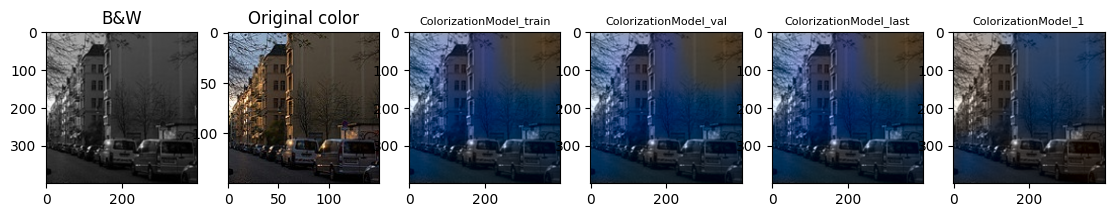

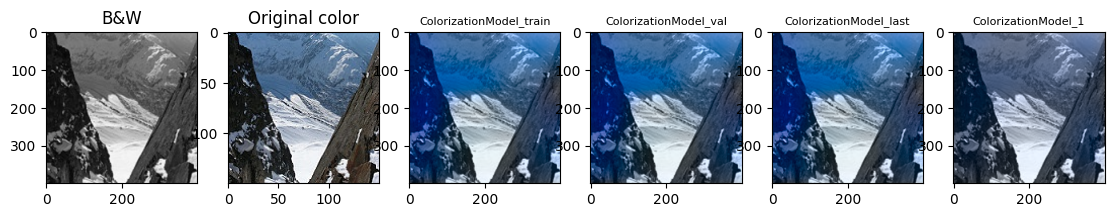

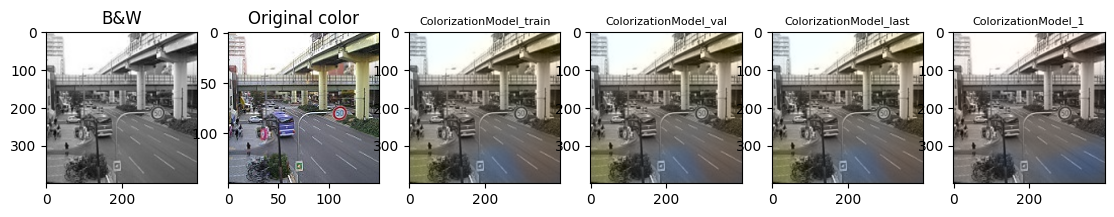

In [9]:
show_demo(models, demo_files1)    

## Изображения из тестовой выборки обучающего датасета

In [10]:
demo_files2 = []

# добавить в demo_files изображения из обучающей выборки
for fn in ["7000", "7100", "7050"]:
    demo_files2.append(
        {'gray': Path(gray_folder_01, f"{fn}.jpg"), 'color': Path(color_folder_01, f"{fn}.jpg")}
    )

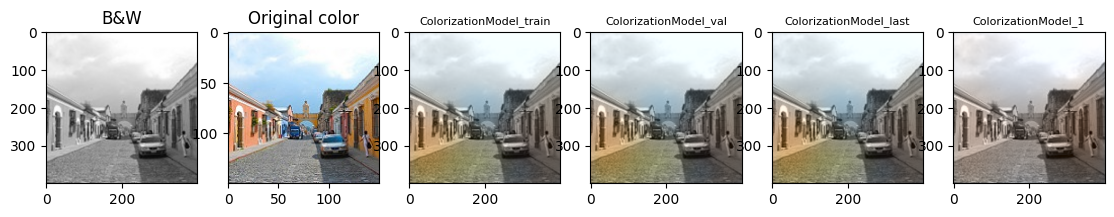

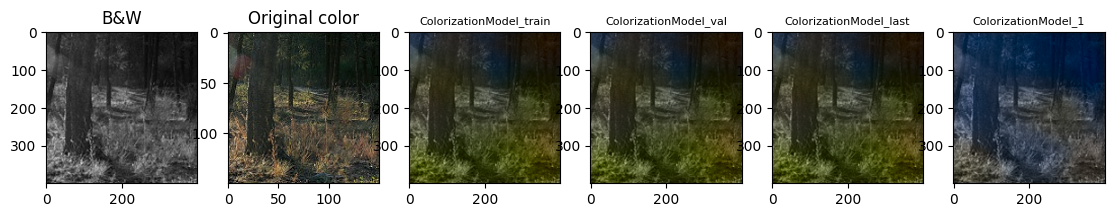

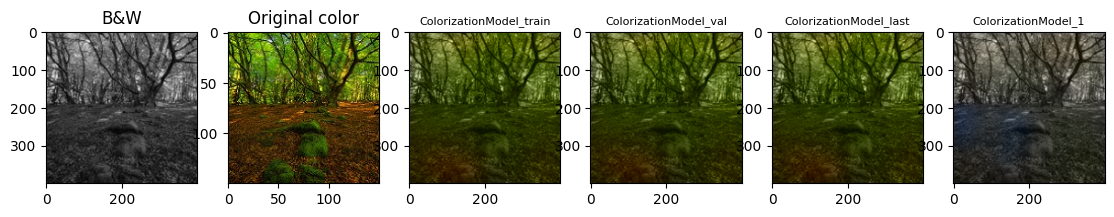

In [11]:
show_demo(models, demo_files2)    

## Изображения из другого датасета

In [12]:
demo_files3 = []

for fn in ["5000", "5729", "5199", "5100"]:
    demo_files3.append(
        {'gray': Path(color_folder_02_test, f"image{fn}.jpg"), 'color': Path(color_folder_02_test, f"image{fn}.jpg")}
    )

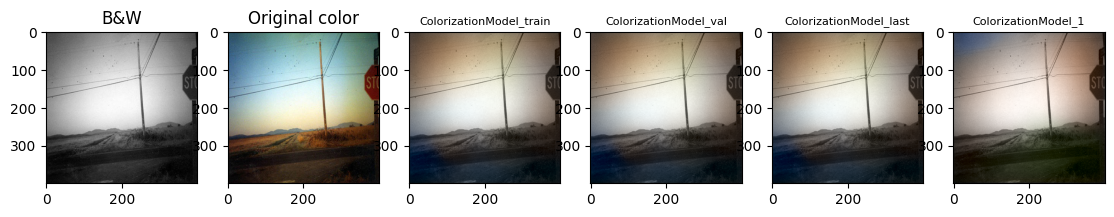

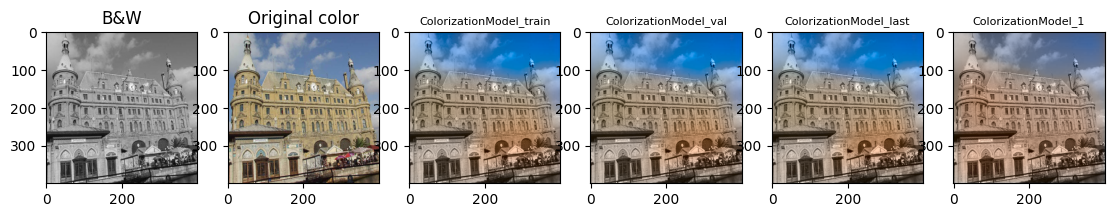

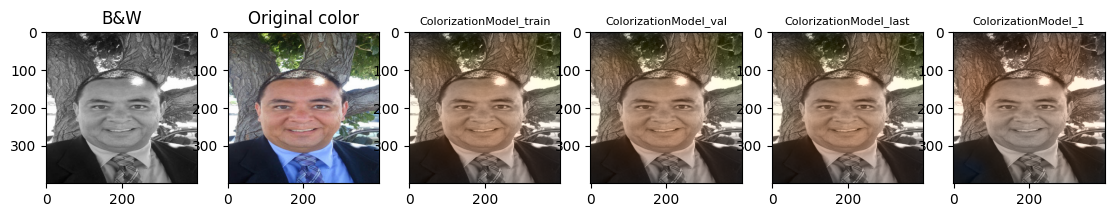

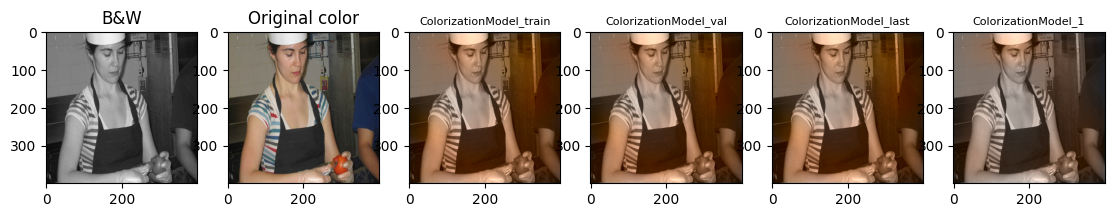

In [13]:
show_demo(models, demo_files3)    